In [2]:
from self_supervised.pipelines.representation_model import RepresentationModel, YoloEncoder
from ultralytics.models.yolo.detect.train import DetectionModel
import torch

%reload_kedro
model_description = catalog.load("yolov8_l_description")
# trained_model = catalog.load("trained_model", version="2023-03-23T12.37.00.000Z")
trained_model = torch.load("../checkpoints/checkpoint_30338.pt", map_location="cpu")

# Random model
# encoder = YoloEncoder(model_description=model_description)
# trained_model = RepresentationModel(encoder=encoder)

# CoCO model
# model_description["head"] = model_description["head"][:-1]
# trained_model = DetectionModel(model_description)
# weights_model = torch.load("../yolov5l.pt", map_location="cpu")
# state_dict = weights_model["model"].float().state_dict()
# trained_model.load_state_dict(state_dict, strict=False)

projection = trained_model.projection
trained_model = trained_model.encoder
trained_model = trained_model.eval()
projection = projection.eval()

2024-03-20 12:55:26,981 - kedro.ipython - INFO - Resolved project path as: /home/daniel/git/self-supervised-learning.
To set a different path, run '%reload_kedro <project_root>'
2024-03-20 12:55:26,991 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/kedro/framework/startup.py:99: KedroDeprecationWarning: project_version in pyproject.toml is deprecated, use kedro_init_version instead
  warnings.warn(

2024-03-20 12:55:27,102 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/kedro/framework/session/session.py:267: KedroDeprecationWarning: TemplatedConfigLoader will be deprecated in Kedro 0.19. Please use the OmegaConfigLoader instead. To consult the documentation for OmegaConfigLoader, see here: https://docs.kedro.org/en/stable/configuration/advanced_configuration.html#omegaconfigloader
  warnings.warn(

2024-03-20 12:55:27,125 - py.warnings - WARNING - /home/daniel/git/self-superv

2024-03-20 12:55:27.506 | INFO     | self_supervised.pipelines.train_simclr.nodes:<module>:43 - Using cpu device.


In [3]:
from pathlib import Path

dataset_path = Path("/home/daniel/lab_share/projects/CottonFlower2021/flower_dataset")

In [4]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from tqdm import tqdm
import torch
from typing import Tuple, List
import numpy as np

def extract_image_reps(image_dir_: Path) -> Tuple[List[np.array], List[np.array]]:
    image_reps = []
    image_reps_low_dim = []

    image_list = sorted(list(image_dir_.iterdir()))
    for image_path in tqdm(image_list):
        image = read_image(image_path.as_posix())
        image.requires_grad = False
        image = resize(image, (512, 512))
        image = image.to(torch.float) / 255
        image_ex = image[None, :, :, :]

        image_rep = trained_model(image_ex).detach()
        image_reps.append(image_rep[0].reshape((1, -1)).numpy())
        image_reps_low_dim.append(projection(image_rep)[0].detach().reshape((1, -1)).numpy())
                          
    return image_reps, image_reps_low_dim

In [5]:
# Extract image reps.
_, ground_image_reps_1 = extract_image_reps(dataset_path / "flower01" / "images")
_, ground_image_reps_2 = extract_image_reps(dataset_path / "flower02" / "images")
_, aerial_image_reps_1 = extract_image_reps(dataset_path / "active_1" / "images")
_, aerial_image_reps_2 = extract_image_reps(dataset_path / "2018-08-22" / "images")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:27<00:00,  5.73it/s]


In [6]:
import pandas as pd
from typing import List
import numpy as np

def read_labels(labels_dir: Path, image_reps: List[np.array]) -> List[int]:
    all_labels = []
    labels_list = sorted(list(labels_dir.iterdir()))
    for labels_path in labels_list:
        frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
        frame_labels["frame"] = labels_path.name
        all_labels.append(frame_labels)

    all_labels = pd.concat(all_labels, ignore_index=True)
    
    # Create flower counts labels.
    flower_counts = []
    for labels_path in labels_list:
        flower_counts.append(np.count_nonzero(all_labels["frame"] == labels_path.name))

    # Any missing counts are zeros.
    for _ in range(len(flower_counts), len(image_reps)):
        flower_counts.append(0)
        
    return flower_counts

In [7]:
# Extract flower counts.
ground_counts_1 = read_labels(dataset_path / "flower01" / "labels", ground_image_reps_1)
ground_counts_2 = read_labels(dataset_path / "flower02" / "labels", ground_image_reps_2)
aerial_counts_1 = read_labels(dataset_path / "active_1" / "labels", aerial_image_reps_1)
aerial_counts_2 = read_labels(dataset_path / "2018-08-22" / "labels", aerial_image_reps_2)

In [8]:
from sklearn.manifold import TSNE

all_image_reps = ground_image_reps_1 + ground_image_reps_2 + aerial_image_reps_1 + aerial_image_reps_2

# Perform TSNE.
tsne = TSNE()
embedded_reps = tsne.fit_transform(np.concatenate(all_image_reps, axis=0))

In [9]:
all_counts = np.array(ground_counts_1 + ground_counts_2 + aerial_counts_1 + aerial_counts_2)

# Combine embeddings with number of flowers and source data.
platform_type = ["ground" for _ in ground_image_reps_1 + ground_image_reps_2] + ["aerial" for _ in aerial_image_reps_1 + aerial_image_reps_2]
embedded_df = pd.DataFrame(data=dict(x=embedded_reps[:, 0], y=embedded_reps[:, 1], num_flowers=all_counts.astype(int), platform=platform_type))
embedded_df

,x,y,num_flowers,platform
0,39.446495,26.121668,2,ground
1,39.364296,26.588734,2,ground
2,39.251308,26.833120,2,ground
3,39.026356,25.805685,2,ground
4,39.066460,26.100029,2,ground
...,...,...,...,...
1106,24.068024,-5.069307,6,aerial
1107,27.419626,-4.664613,2,aerial
1108,22.109123,-9.876672,1,aerial
1109,19.933025,-10.927812,3,aerial


[Text(0.5, 1.0, 't-SNE Embedding of Validation Datasets')]

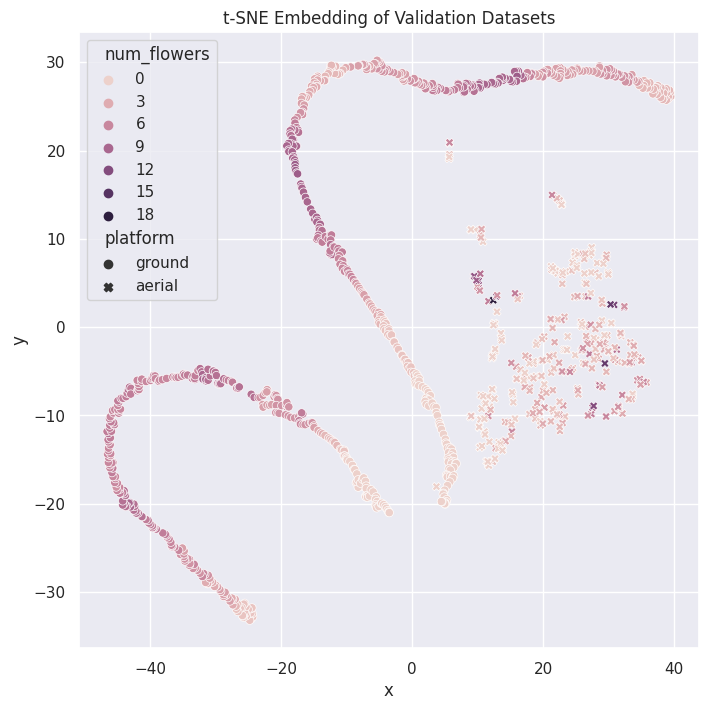

In [10]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize":(8, 8)})

sns.scatterplot(data=embedded_df, x="x", y="y", hue="num_flowers", style="platform").set(title="t-SNE Embedding of Validation Datasets")

In [11]:
tsne_aerial = TSNE()
aerial_embedded_reps = tsne_aerial.fit_transform(np.concatenate(aerial_image_reps_1 + aerial_image_reps_2, axis=0))

In [12]:
# Combine embeddings with number of flowers and source data.
aerial_embedded_df = pd.DataFrame(data=dict(x=aerial_embedded_reps[:, 0], y=aerial_embedded_reps[:, 1], num_flowers=np.array(aerial_counts_1 + aerial_counts_2).astype(int)))
aerial_embedded_df

,x,y,num_flowers
0,-8.728724,5.314911,1
1,2.470880,2.666160,1
2,-9.054522,-8.185902,8
3,-16.358620,6.931526,0
4,-9.650965,12.546474,1
...,...,...,...
315,-0.587493,-2.089130,6
316,-2.526519,2.123245,2
317,2.912324,-6.600740,1
318,7.491395,-7.821366,3


[Text(0.5, 1.0, 't-SNE Embedding of Aerial Dataset')]

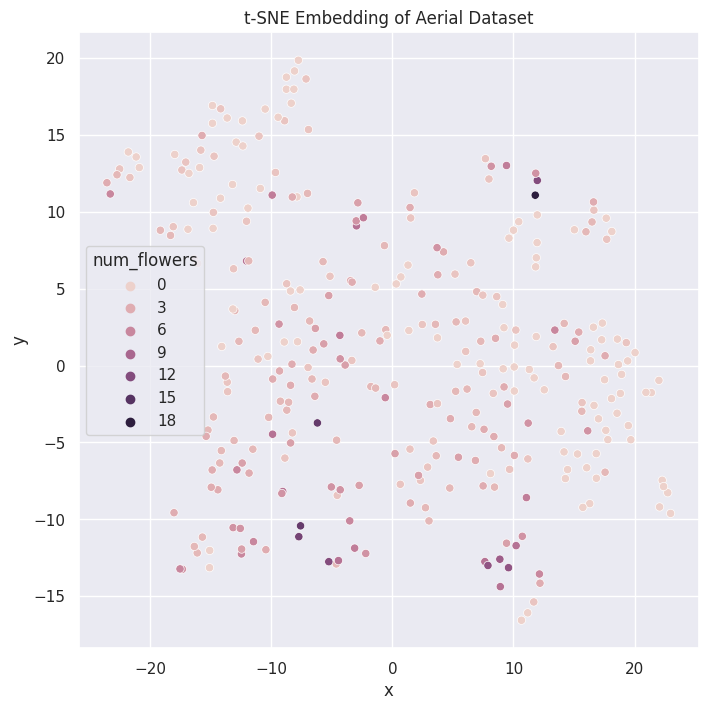

In [13]:
sns.scatterplot(data=aerial_embedded_df, x="x", y="y", hue="num_flowers").set(title="t-SNE Embedding of Aerial Dataset")